In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'rice-image-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2049052%2F3399185%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240824%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240824T141627Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dc3045862115781637f57ae1f671f9b36bfe3921902bce4481a10a447247fd27f859b2359a4c7fe9ad697004d0b2de63a37c69149000d82e118302722deefdc47d20af456b9b6b58727a1d6072fa52dc2db957679da6303296ce0f0af0c4e83f54ddf0bf8e25699f583e9f3a72c75ac2d06616473153b225f14e260743b54b82cfc46474f3dd3821f88e35ba09ba3ba5ea1e4154db5916ece9cab90c75f0379a72c8bf7ac4fac18af4d07b26918dff671f5163b6f6cf2e85d7e4645b079cc56af3e41a8eeb8fea5c9534f7afd95e474e818576193b781fd7fdea4ead4aa0409a3c642a2a39b40b305ac6d94b5d0a91e75489f4a6c57307cf394e166b2c5e4dc28'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 230059472 bytes downloaded
Downloaded and uncompressed: rice-image-dataset
Data source import complete.


# 1. Mengimpor Library

Pada tahap awal, kita akan mengimpor seluruh library yang diperlukan dalam notebook ini.

In [2]:
import os
import time
import keras
import random
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tabulate import tabulate
from keras.models import Sequential
from keras import models, layers, optimizers
from sklearn.metrics import confusion_matrix, classification_report
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
sns.set_style("whitegrid")

# 2. Data Gathering

Dataset diambil dari kaggle pada link [berikut](https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset). Data berupa gambar beras yang dibagi menjadi beberapa kelas.

In [3]:
# Mengambil dataset
dataset = "/kaggle/input/rice-image-dataset/Rice_Image_Dataset"

# Mendeteksi kelas-kelas yang ada di dataset
deteksi_kelas = [nama_kelas for nama_kelas in os.listdir(dataset) if nama_kelas]

# Membuang file bernama Rice_Citation_Request.txt
deteksi_kelas.remove("Rice_Citation_Request.txt")
print(deteksi_kelas)

['Arborio', 'Basmati', 'Jasmine', 'Karacadag', 'Ipsala']


Dapat dilihat bahwa terdapat 5 kelas dalam data, yaitu **Karacadag**, **Basmati**, **Jasmine**, **Arborio**, dan **Ipsala**.

# 3. Data Assessing

Selanjutnya kita akan melihat sampel gambar dari masing-masing kelas yang ada dalam dataset agar kita mendapatkan gambaran mengenai gambar-gambar yang ada.

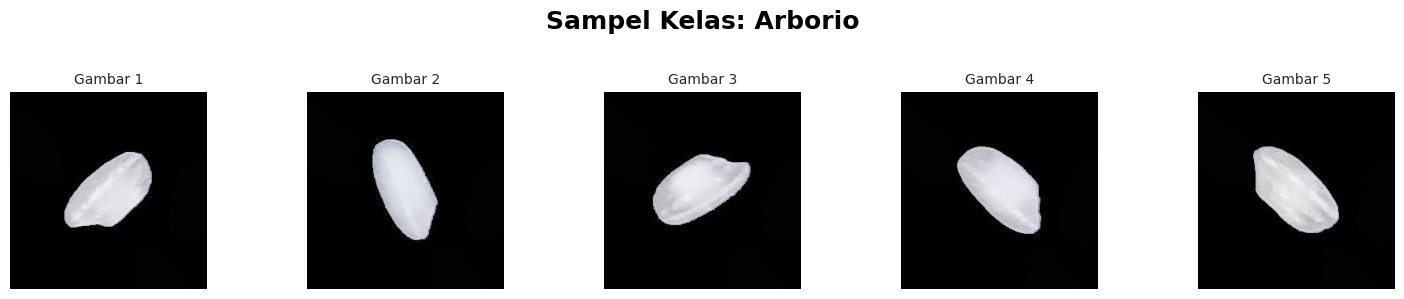

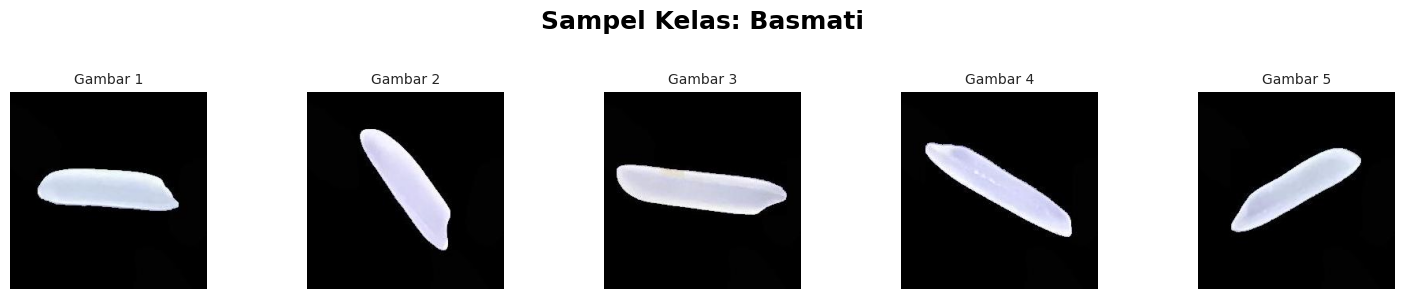

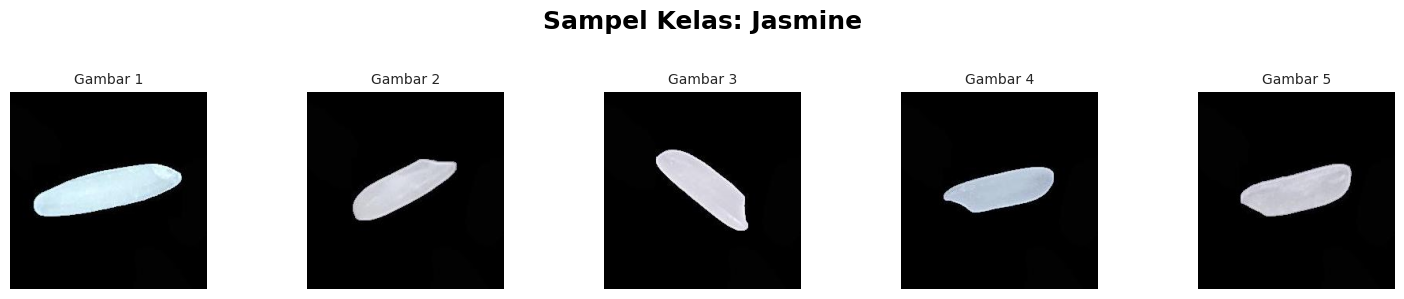

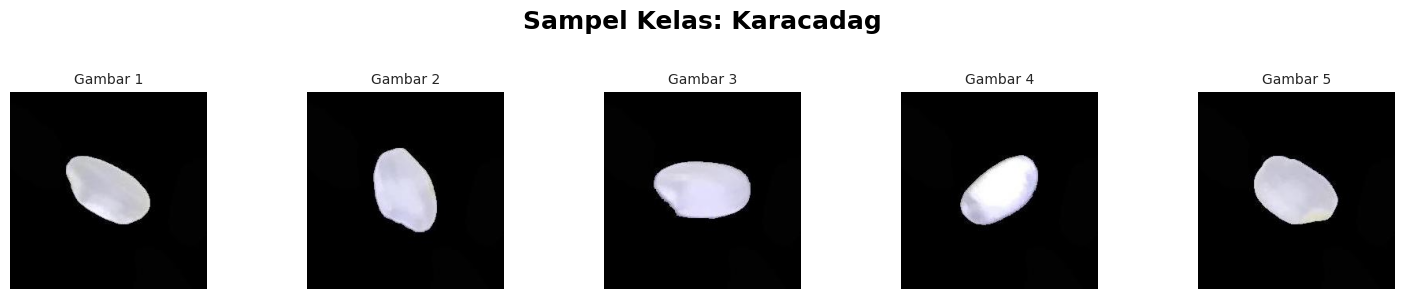

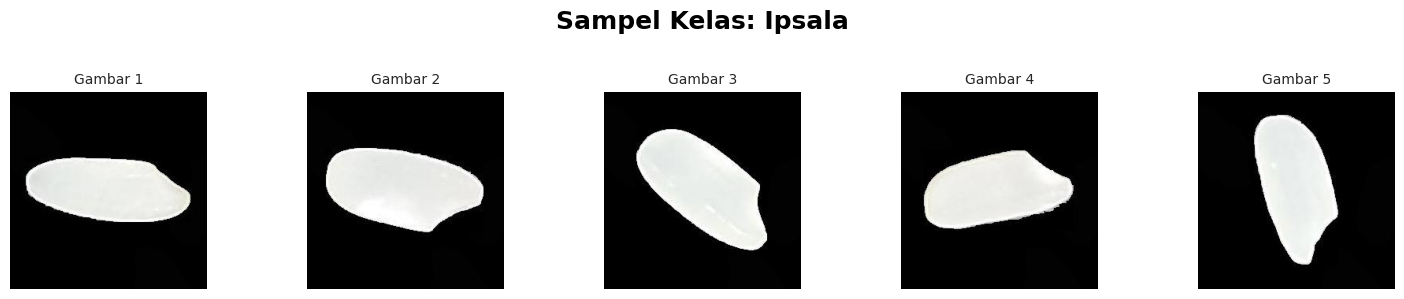

In [4]:
# Kode ini digunakan untuk menampilkan sampel gambar dari masing-masing kelas
for nama_kelas in deteksi_kelas:
    # Mendefinisikan path dari kelas
    class_path = os.path.join(dataset, nama_kelas)

    # Membuat list gambar berisi 5 gambar acak
    images = os.listdir(class_path)
    random_images = random.choices(images, k = 5)

    # Membuat plot berukuran 1x5 dengan judul sesuai kelas dari sampel
    fig, ax = plt.subplots(1, 5, figsize = (15, 3))
    plt.suptitle(f"Sampel Kelas: {nama_kelas}", fontsize = 18, fontweight = "bold", color = "black")

    for i in range(5):
        # Menampilkan gambar random dari masing-masing kelas
        img_path = os.path.join(class_path, random_images[i])
        img = keras.utils.load_img(img_path)
        ax[i].imshow(img)

        # Menghapus sumbu karena tidak diperlukan
        ax[i].axis("off")

        # Menuliskan judul gambar
        ax[i].set_title(f"Gambar {i + 1}", fontsize = 10)

    # Mengatur layout gambar
    plt.tight_layout(rect = [0, 0, 1, 0.9])

    # Menampilkan gambar
    plt.show()

Selanjutnya, kita akan menghitung jumlah gambar dari masing-masing kelas untuk mengetahui apakah jumlah data yang ada telah seimbang atau belum.

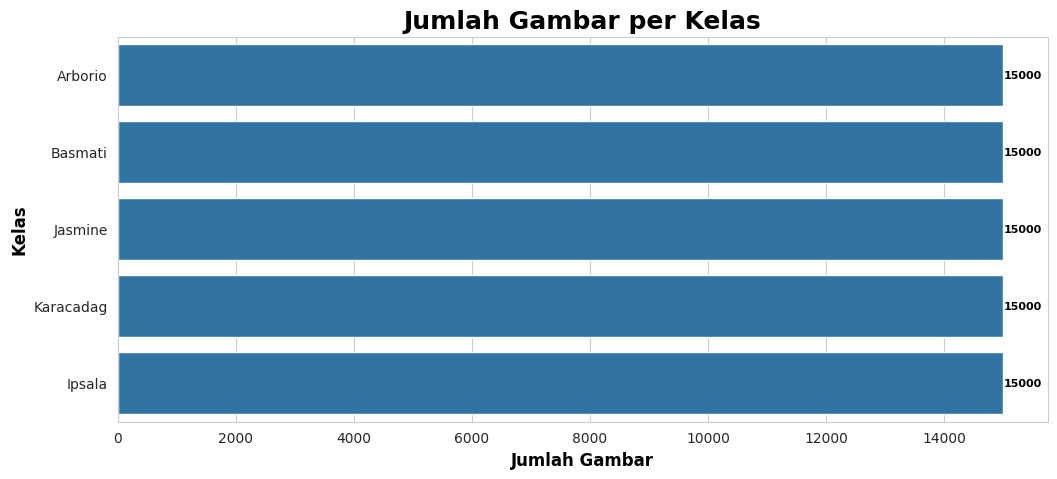

In [5]:
# Kode ini digunakan untuk menghitung jumlah gambar masing-masing kelas
counts = []
for nama_kelas in deteksi_kelas:
    class_path = os.path.join(dataset, nama_kelas)
    counts.append(len(os.listdir(class_path)))

# Membentuk barplot horizontal, yaitu kelas sebagai sumbu Y dan jumlah sebagai sumbu X
plt.figure(figsize = (12, 5))
ax = sns.barplot(y = deteksi_kelas, x = counts)

# Memberi anotasi pada setiap bar dengan jumlah gambar
for i, p in enumerate(ax.patches):
    width = p.get_width()
    ax.text(width + 5, p.get_y() + p.get_height()/2., "{}".format(counts[i]),
            va = "center", fontsize = 8, color = "black", fontweight = "semibold")

# Memberikan judul pada gambar
plt.title("Jumlah Gambar per Kelas", fontsize = 18, fontweight = "bold", color = "black")

# Memberikan label pada sumbu Y
plt.ylabel("Kelas", fontsize = 12, fontweight = "bold", color = "black")

# Memberikan label pada sumbu x
plt.xlabel("Jumlah Gambar", fontsize = 12, fontweight = "bold", color = "black")

# Menampilkan gambar
plt.show()

Dari gambar di atas, dapat dilihat bahwa setiap kelas memiliki jumlah gambar sebsar 15000, sehingga total gambar yang ada adalah 75000. Karena jumlah gambar seimbang untuk setiap kelas, maka tidak perlu dilakukan penambahan gambar.

# 4. Data Preprocessing

Selanjutnya, seluruh gambar yang ada akan dibentuk menjadi DataFrame berdasarkan path gambar beserta kelas dari gambar tersebut.

In [6]:
# Kode ini digunakan untuk membuat DataFrame dari seluruh gambar
# Membentuk list kosong
image_data = []

# Membentuk list berisi tuple yang berisi path dari masing-masing gambar beserta kelasnya
for nama_kelas in deteksi_kelas:
    # Membentuk path dari kelas
    class_path = os.path.join(dataset, nama_kelas)

    # Mencatat seluruh file yang ada di tiap kelas
    files = os.listdir(class_path)

    # Perulangan terhadap seluruh file
    for file in files:
        # Membentuk path dari setiap file
        file_path = os.path.join(class_path, file)

        # Menggabungkan path dari setiap file dengan kelas yang bersesuaian
        image_data.append((file_path, nama_kelas))

# Mengubah list menjadi DataFrame berisi path dan kelasnya
df = pd.DataFrame(image_data, columns = ["path", "label"])

# Mengacak baris pada DataFrame untuk meningkatkan keacakan data
df = df.sample(frac = 1).reset_index(drop = True)

# Menampilkan 5 baris teratas dari DataFrame
df.head()

,path,label
0,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Arborio
1,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Ipsala
2,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Basmati
3,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Jasmine
4,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Arborio


In [7]:
# Kode ini digunakan untuk membagi data menjadi data training dan data testing
jumlah_sampel = len(df)
print(f"Jumlah sampel: {jumlah_sampel}")

# Karena jumlah gambar sebanyak 75000, maka diambil 60000 sebagai data training (80%)
data_training = df[:60000]

# Karena jumlah gambar sebanyak 75000, maka diambil 15000 sebagai data testing (20%)
data_testing = df[60000:]

data_training.reset_index(inplace = True, drop = True)
data_testing.reset_index(inplace = True, drop = True)

print(f"Jumlah sampel pada data training: {len(data_training)}")
print(f"Jumlah sampel pada data testing: {len(data_testing)}")

Jumlah sampel: 75000
Jumlah sampel pada data training: 60000
Jumlah sampel pada data testing: 15000


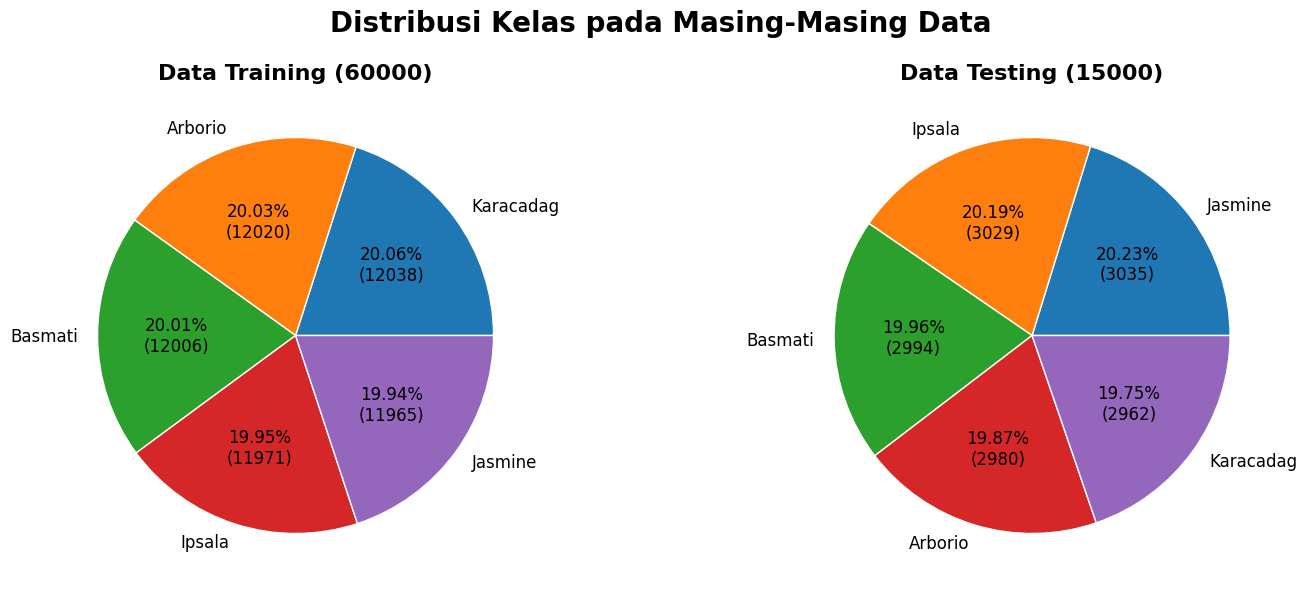

In [8]:
# Menghitung jumlah dari masing-masing kelas
category_counts = df["label"].value_counts()
categories = category_counts.index.tolist()
counts = category_counts.values.tolist()

# Membentuk plot yang terdiri 2 plot untuk data training dan data testing
fig, axs = plt.subplots(1, 2, figsize = (15, 6))

# Menghitung jumlah masing-masing kelas pada masing-masing data
for i, (subset, subset_name) in enumerate(zip([data_training, data_testing], ["Data Training", "Data Testing"])):
    subset_category_counts = subset["label"].value_counts()
    subset_counts = subset_category_counts.values.tolist()
    total_count = len(subset)
    percentages = [count / total_count * 100 for count in subset_counts]

    # Membentuk pie chart untuk masing-masing data
    wedges, _, autotexts = axs[i].pie(
        subset_counts,
        labels = subset_category_counts.index,
        autopct = lambda p: f"{p:.2f}%\n({total_count * p / 100:.0f})",
        textprops = {"color": "black", "fontsize": 12}
    )

    # Memberikan judul pada masing-masing pie chart
    axs[i].set_title(f"{subset_name} ({total_count})", fontsize = 16, fontweight = "bold", color = "black")

    # Mengatur posisi label dalam pie chart agar berada di tengah
    for autotext in autotexts:
        autotext.set_horizontalalignment("center")
        autotext.set_verticalalignment("center")

# Menambahkan judul pada gambar yang dibuat
plt.suptitle("Distribusi Kelas pada Masing-Masing Data", fontsize = 20, fontweight = "bold", color = "black")
plt.tight_layout()

# Mengatur margin atas pada gambar
plt.subplots_adjust(top = 0.85)

# Menampilkan gambar
plt.show()

Selanjutnya, kita akan melakukan normalisasi pada data dengan `ImageDataGenerator` serta membentuk data generator untuk data training maupun data testing.

In [9]:
# Menggunakan ImageDataGenerator untuk normalisasi gambar
data_generator = ImageDataGenerator(rescale = 1.0/255)

# Membuat fungsi untuk membentuk data generator
def create_data_generator(dataframe, is_training = False):
    return data_generator.flow_from_dataframe(
        dataframe,
        x_col = "path",
        y_col = "label",
        target_size = (224, 224),
        batch_size = 16,
        class_mode = "categorical",
        shuffle = is_training)

# Memanggil fungsi membentuk data generator untuk data training dan data testing
train_generator = create_data_generator(data_training, is_training = True)
test_generator = create_data_generator(data_testing, is_training = False)

Found 60000 validated image filenames belonging to 5 classes.
Found 15000 validated image filenames belonging to 5 classes.


Setelah data selesai diproses, selanjutnya akan dibuat model machine learning.

# 5. Pemodelan

Pemodelan pada proyek ini menggunakan algoritma Convolutional Neural Network (CNN).

In [10]:
# Membentuk Model CNN dengan Sequential()
model = Sequential()

# Layer pertama
model.add(Conv2D(32, (3, 3), activation = "relu", input_shape = (224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))

# Layer kedua
model.add(Conv2D(64, (3, 3), activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))

# Layer ketiga
model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.5))

# Layer keempat
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))

# Layer output
model.add(Dense(len(data_training["label"].unique()), activation = "softmax"))

# Compile model dengan optimizer Adam dan metrik akurasi
model.compile(loss = "categorical_crossentropy",
              optimizer = optimizers.Adam(learning_rate = 0.001),
              metrics = ["accuracy"])

# Menampilkan bentuk model yang telah dibuat
model.summary()

print("Model CNN telah selesai dibuat dan siap untuk dilatih")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      95,552,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,638,085 (364.83 MB)

 Trainable params: 95,637,893 (364.83 MB)

 Non-trainable params: 192 (768.00 B)

Model CNN telah selesai dibuat dan siap untuk dilatih


Untuk menyingkat waktu pelatihan bila dimungkinkan, kita akan menggunakan callbacks agar pelatihan berhenti jika akurasi telah mencapai yang diinginkan.

In [11]:
# Mengimplementasikan callback dengan batas bawah akurasi 97%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if (logs.get("accuracy") > 0.97) and (logs.get("val_accuracy") > 0.97):
            print("\nModel selesai dilatih karena akurasi telah lebih dari 97%!")
            self.model.stop_training = True

callbacks = myCallback()

Setelah model dan callbacks dibuat, kita akan melatih model yang telah dibuat.

In [12]:
# Memulai timer
start_time = time.time()

# Melatih model sebanyak 10 epoch
history = model.fit(train_generator,
                    epochs = 10,
                    validation_data = test_generator,
                    callbacks = callbacks)

# Memberhentikan timer
end_time = time.time()

# Menghitung total waktu pelatihan untuk model
training_time = end_time - start_time
print(f"\nTotal waktu model dilatih: {training_time:.2f} detik")

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3750/3750 ━━━━━━━━━━━━━━━━━━━━ 188s 47ms/step - accuracy: 0.7329 - loss: 5.0250 - val_accuracy: 0.9602 - val_loss: 0.1387
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 191s 46ms/step - accuracy: 0.8848 - loss: 0.4115 - val_accuracy: 0.9423 - val_loss: 0.1607
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 173s 46ms/step - accuracy: 0.9366 - loss: 0.2363 - val_accuracy: 0.8811 - val_loss: 0.3304
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 173s 46ms/step - accuracy: 0.9509 - loss: 0.2063 - val_accuracy: 0.9436 - val_loss: 0.2203
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 171s 46ms/step - accuracy: 0.9610 - loss: 0.1706 - val_accuracy: 0.9394 - val_loss: 0.3995
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 202s 46ms/step - accuracy: 0.9537 - loss: 0.1888 - val_accuracy: 0.9727 - val_loss: 0.0992
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 202s 46ms/step - accuracy: 0.9674 - loss: 0.1276 - val_accuracy: 0.9327 - val_loss: 2.3788
Epoch 8/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 175s 47ms/step - accuracy: 0.9733 - lo

Dapat dilihat bahwa model selesai dilatih setelah 9 epoch dijalankan dengan berhasil mendapatkan akurasi di atas 97% untuk data training maupun data testing. Selanjutnya, akan ditampilkan akurasi beserta lossnya dalam bentuk DataFrame.

In [13]:
# Menampilkan hasil pelatihan dalam bentuk DataFrame
hasil_training = pd.DataFrame(history.history)
print(tabulate(hasil_training, headers = "keys", tablefmt = "psql"))

+----+------------+----------+----------------+------------+
|    |   accuracy |     loss |   val_accuracy |   val_loss |
|----+------------+----------+----------------+------------|
|  0 |   0.805817 | 1.61572  |       0.9602   |  0.13873   |
|  1 |   0.895383 | 0.375469 |       0.942333 |  0.160657  |
|  2 |   0.9385   | 0.228041 |       0.881067 |  0.330447  |
|  3 |   0.949967 | 0.215702 |       0.9436   |  0.220316  |
|  4 |   0.964883 | 0.154264 |       0.9394   |  0.399488  |
|  5 |   0.954983 | 0.185449 |       0.972733 |  0.0991538 |
|  6 |   0.969633 | 0.128554 |       0.932667 |  2.37875   |
|  7 |   0.975933 | 0.114876 |       0.919067 |  0.331191  |
|  8 |   0.97975  | 0.102168 |       0.972667 |  0.083651  |
+----+------------+----------+----------------+------------+


# 6. Evaluasi

Setelah model selesai dilatih, kita akan melihat akurasi dan loss pada model dalam bentuk grafik.

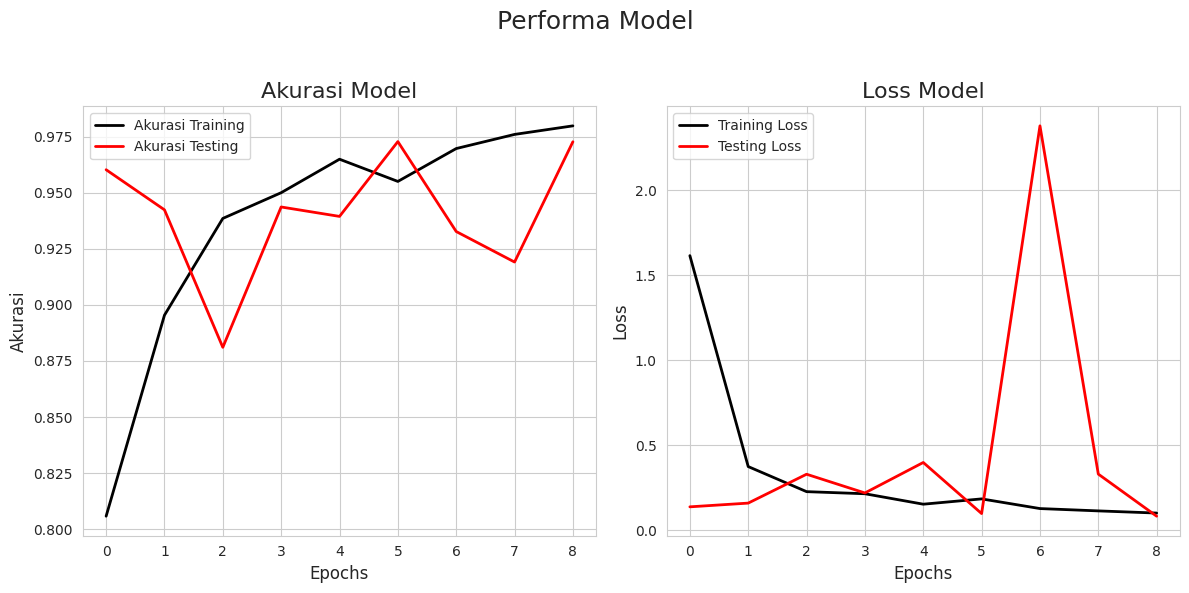

In [14]:
# Mendefinisikan variabel epoch yang merupakan jumlah epoch pada pelatihan
epoch = np.arange(len(hasil_training))

# Membentuk gambar berisi 2 sub gambar
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
fig.suptitle("Performa Model", fontsize = 18)

# Membentuk gambar yang menampilkan performa akurasi pada model
ax[0].plot(epoch, hasil_training.accuracy, label = "Akurasi Training", linewidth = 2, color = "black")
ax[0].plot(epoch, hasil_training.val_accuracy, label = "Akurasi Testing", linewidth = 2, color = "red")
ax[0].set_title("Akurasi Model", fontsize = 16)
ax[0].set_xlabel("Epochs", fontsize = 12)
ax[0].set_ylabel("Akurasi", fontsize = 12)
ax[0].legend()
ax[0].grid(True)

# Membentuk gambar yang menampilkan performa loss pada model
ax[1].plot(epoch, hasil_training.loss, label = "Training Loss", linewidth = 2, color = "black")
ax[1].plot(epoch, hasil_training.val_loss, label = "Testing Loss", linewidth = 2, color= "red")
ax[1].set_title("Loss Model", fontsize = 16)
ax[1].set_xlabel("Epochs", fontsize = 12)
ax[1].set_ylabel("Loss", fontsize = 12)
ax[1].legend()
ax[1].grid(True)

# Mengatur layout gambar
plt.tight_layout(rect = [0, 0, 1, 0.95])

# Menampilkan gambar
plt.show()

# 7. Konversi Model

In [15]:
# Menyimpan model dalam format SavedModel
export_dir = "saved_model/"
tf.saved_model.save(model, export_dir)

In [19]:
# Convert model menjadi model.tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path("model.tflite")
tflite_model_file.write_bytes(tflite_model)

Saved artifact at '/tmp/tmpv4gh6e7q'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  139151312855712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139151313001232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139151312999296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139151313004224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139151313002640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139151313001584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139151313503856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139151313506320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139151313505616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139151313510016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13915131350596

382556548

In [17]:
# Install tensorflowjs
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 101.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [21]:
model.save("model.h5")

# Konversi model.h5 ke tfjs_model
!tensorflowjs_converter --input_format keras \
    --weight_shard_size_bytes 4294967296 \
    model.h5 tfjs_model

2024-08-24 15:28:01.647213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-24 15:28:01.672750: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-24 15:28:01.688291: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-24 15:28:02.711330: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
failed to lookup keras version from the file,
    this is likely a weight only file


In [20]:
pip freeze requirements.txt

absl-py==1.4.0
accelerate==0.32.1
aiohappyeyeballs==2.4.0
aiohttp==3.10.5
aiosignal==1.3.1
alabaster==0.7.16
albucore==0.0.13
albumentations==1.4.14
altair==4.2.2
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.18.0
asn1crypto==1.5.1
astropy==6.1.2
astropy-iers-data==0.2024.8.19.0.32.16
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==24.2.0
audioread==3.0.1
autograd==1.6.2
babel==2.16.0
backcall==0.2.0
beautifulsoup4==4.12.3
bidict==0.23.1
bigframes==1.15.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.4.3
bqplot==0.12.43
branca==0.7.2
build==1.2.1
CacheControl==0.14.0
cachetools==5.5.0
catalogue==2.0.10
certifi==2024.7.4
cffi==1.17.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.86
clarabel==0.9.0
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpathlib==0.18.1
cloudpickle==2.2.1
cmake==3.30.2
cmdstanpy==1.2.4
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confe